In [1]:
!pip install transformers datasets huggingface_hub tensorboard==2.11
!sudo apt-get install git-lfs --yes
! pip install transformers[torch] -U
! pip install accelerate -U
!pip install wget

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [2]:
import json
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TextClassificationPipeline
from huggingface_hub import HfFolder, notebook_login
import wget
import os
import pandas as pd
from datasets import Dataset, load_dataset
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
#Logging in into Hugging Face
notebook_login()


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Paths to the new dataset files
train_jsonl_path = "/content/drive/My Drive/dataset_with_n/arxiv_bloomz_train.jsonl"
test_jsonl_path = "/content/drive/My Drive/dataset_with_n/arxiv_bloomz_test.jsonl"
validation_jsonl_path = "/content/drive/My Drive/dataset_with_n/arxiv_bloomz_validation.jsonl"

In [6]:
# Function to load a dataset from a JSONL file
def load_jsonl_to_dataset(jsonl_path):
    data = []
    with open(jsonl_path, 'r') as file:
        for line in file:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                continue  # Skip lines that are not valid JSON
    return data

In [7]:
# Load datasets
train_data = load_jsonl_to_dataset(train_jsonl_path)
test_data = load_jsonl_to_dataset(test_jsonl_path)
validation_data = load_jsonl_to_dataset(validation_jsonl_path)

In [ ]:
train_data[0]

{'source_id': 705.0379,
 'title': 'Supersymmetric Q Solitons of Arbitrary Genus',
 'abstract': '  We construct "Flying Saucer" solitons in supersymmetric N=2 gauge theory\nwhich is known to support BPS domain walls with a U(1) gauge field localized on\nits worldvolume. We demonstrate that this model supports exotic particle-like\nsolitons whose topology is largely arbitrary: closed orientable surfaces in\nthree-dimensional space which can have arbitrary genus. In particular, we focus\non Q tori. Q tori and similar solitons of higher genera are obtained by folding\nthe domain wall into an appropriate surface. Nontrivial cycles on the domain\nwall worldvolume (handles) are stabilized by crossed electric and magnetic\nfields inside the folded domain wall. Three distinct frameworks are used to\nprove the existence of these Flying Saucer solitons and study their properties:\nthe worldvolume description (including the Dirac-Born-Infeld action), the bulk\ntheory description in the sigma-model

In [ ]:
test_data[0]

{'source_id': 705.2519,
 'title': 'Faithful Effective-One-Body waveforms of small-mass-ratio coalescing black-hole binaries',
 'abstract': "  We address the problem of constructing high-accuracy, faithful analytic\nwaveforms describing the gravitational wave signal emitted by inspiralling and\ncoalescing binary black holes. We work within the Effective-One-Body (EOB)\nframework and propose a methodology for improving the current\n(waveform)implementations of this framework based on understanding, element by\nelement, the physics behind each feature of the waveform, and on systematically\ncomparing various EOB-based waveforms with ``exact'' waveforms obtained by\nnumerical relativity approaches. The present paper focuses on small-mass-ratio\nnon-spinning binary systems, which can be conveniently studied by\nRegge-Wheeler-Zerilli-type methods. Our results include: (i) a resummed,\n3PN-accurate description of the inspiral waveform, (ii) a better description of\nradiation reaction during t

In [ ]:
validation_data[0]

{'source_id': 705.2166,
 'title': 'Ultimate Fate of our Universe from Quantum Mechanics',
 'abstract': '  It is conjectured that time intervals of any kind are proportional to the age\nof the Universe taken at the time we are considering the interval. If this is\nthe case then the speed of light, in fact any speed, must decrease inversely\nproportional to this age. The immediate consequence is that energy is not\nconserved: the hypothesis that time is a homogeneous property implies\nconservation of energy (the theorem of Noether). Nonconservation of energy\nfollows from the condition that any time interval is proportional to the\ncosmological time, and therefore time can not be homogeneous. From the\nuncertainty principle, taking the constant of Planck as a real constant, time\nindependent, it follows that any energy in the Universe decreases linearly with\ntime. We then prove that Schroedinger equation does not change, except for the\npotential energy term. The future of the Universe 

In [8]:
def prepare_dataset(data):
    examples = []
    labels = []

    # Append text and labels for human and machine texts
    for example in data:
        examples.append(example["abstract"])
        labels.append(0)  # Human text label
        examples.append(example["machine_abstract"])
        labels.append(1)  # Machine text label

    # Creating a dataset
    dataset = Dataset.from_dict({"text": examples, "labels": labels})

    return dataset

In [9]:
# Prepare datasets
train_dataset = prepare_dataset(train_data)
test_dataset = prepare_dataset(test_data)
validation_dataset = prepare_dataset(validation_data)

In [ ]:
train_dataset[0]

{'text': '  We construct "Flying Saucer" solitons in supersymmetric N=2 gauge theory\nwhich is known to support BPS domain walls with a U(1) gauge field localized on\nits worldvolume. We demonstrate that this model supports exotic particle-like\nsolitons whose topology is largely arbitrary: closed orientable surfaces in\nthree-dimensional space which can have arbitrary genus. In particular, we focus\non Q tori. Q tori and similar solitons of higher genera are obtained by folding\nthe domain wall into an appropriate surface. Nontrivial cycles on the domain\nwall worldvolume (handles) are stabilized by crossed electric and magnetic\nfields inside the folded domain wall. Three distinct frameworks are used to\nprove the existence of these Flying Saucer solitons and study their properties:\nthe worldvolume description (including the Dirac-Born-Infeld action), the bulk\ntheory description in the sigma-model limit, and the bulk theory description in\nthe thin-edge approximation. In the sigma-

In [ ]:
train_dataset[1]

{'text': 'We present the first explicit construction of supersymmetric quantum solitons in any dimension and for an arbitrary number of colors N . The solutions are obtained by solving a set of coupled nonlinear partial differential equations, which we solve numerically using a relaxation method. We find that there is always at least one solution with zero energy density (the vacuum). For large values of N , we also find solutions with nontrivial energy densities. These results provide further evidence that the theory has a rich spectrum of excitations. Supersymmetry plays a crucial role in our analysis; it allows us to reduce the problem to finding solutions of ordinary differential equations instead of partial differential equations. \nIntroduction: In this work, we study the dynamics of a class of field theories known as supersymmetric gauge theories. Such theories have been studied extensively over the past few years because they play important roles in many areas of physics includ

In [10]:
print("Size of the train dataset:", len(train_dataset))
print("Size of the test dataset:", len(test_dataset))
print("Size of the validation dataset:", len(validation_dataset))

Size of the train dataset: 3840
Size of the test dataset: 1200
Size of the validation dataset: 960


Had to use max_length = 256, as max_length = 512 gave Out-of-memory error even on high-end GPU

In [ ]:
# Load tokenizer and model
model_name = "andreas122001/bloomz-560m-academic-detector"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/324 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

In [ ]:
# Tokenize the text data
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length = 256)

In [ ]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
validation_dataset = validation_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/3840 [00:00<?, ? examples/s]

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

In [ ]:
print("Size of the train dataset:", len(train_dataset))
print("Size of the test dataset:", len(test_dataset))
print("Size of the validation dataset:", len(validation_dataset))

Size of the train dataset: 3840
Size of the test dataset: 1200
Size of the validation dataset: 960


In [ ]:
# TrainingArguments
training_args = TrainingArguments(
    output_dir="/content/drive/My Drive/bloomz-560m-academic-detector-finetuned",
    num_train_epochs=5,
    per_device_train_batch_size=4,  # Adjusted for potential GPU memory constraints
    per_device_eval_batch_size=4,
    evaluation_strategy="epoch",
    logging_dir="/content/drive/My Drive/bloomz-560m-academic-detector-finetuned/logs",
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=500,
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=2,
    report_to="tensorboard",
    push_to_hub=False,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
)

In [ ]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
# Fine-tune the model
trainer.train()

evaluation_results = trainer.evaluate()
print(evaluation_results)

Epoch,Training Loss,Validation Loss
1,0.000000,0.000000
2,0.000000,0.000000
3,0.000000,0.000000
4,0.000000,0.000000
5,0.000000,0.000000


{'eval_loss': 1.2417633588057697e-10, 'eval_runtime': 17.8085, 'eval_samples_per_second': 53.907, 'eval_steps_per_second': 13.477, 'epoch': 5.0}


In [ ]:
output_dir = "/content/drive/My Drive/bloomz-560m-academic-detector-finetuned"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the trained model
model.save_pretrained(output_dir)

In [ ]:
!ls "/content/drive/MyDrive/bloomz-560m-academic-detector-finetuned"


checkpoint-4800  checkpoint-960  config.json  logs  model.safetensors


In [ ]:
# !pip install caffe2


In [ ]:
# from torch.utils.tensorboard import SummaryWriter
# import os
# # Path to the events log file
# log_dir = "/content/drive/My Drive/bloomz-560m-academic-detector-finetuned/logs"  # Change this to the directory where your logs are stored
# events_file = os.path.join(log_dir, "events.out.tfevents.XXXXXX")

# # Create SummaryWriter
# writer = SummaryWriter(log_dir=log_dir)

# # Read events from the log file
# writer.add_graph("model", events_file)

# # Close SummaryWriter
# writer.close()

# TESTING

## Testing with merged dataset of human_generated and machine_generated abstracts from held-out test_dataset

In [ ]:
# Define the directory where the model and tokenizer are located
model_directory = "/content/drive/My Drive/bloomz-560m-academic-detector-finetuned"

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
model = AutoModelForSequenceClassification.from_pretrained(model_directory)

# Create a classification pipeline
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)

def classify_text(example):
    # This function will be applied to each example
    predictions = classifier(example['text'])
    # Assuming the most likely label's id is returned directly
    return {'predicted_labels': predictions[0]['label']}

# Apply the classification to all texts in the dataset and add the predicted_labels column
test_dataset = test_dataset.map(classify_text, batched=False)

# Check the first few entries to verify
print(test_dataset[0])
print(test_dataset[1])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': "  We address the problem of constructing high-accuracy, faithful analytic\nwaveforms describing the gravitational wave signal emitted by inspiralling and\ncoalescing binary black holes. We work within the Effective-One-Body (EOB)\nframework and propose a methodology for improving the current\n(waveform)implementations of this framework based on understanding, element by\nelement, the physics behind each feature of the waveform, and on systematically\ncomparing various EOB-based waveforms with ``exact'' waveforms obtained by\nnumerical relativity approaches. The present paper focuses on small-mass-ratio\nnon-spinning binary systems, which can be conveniently studied by\nRegge-Wheeler-Zerilli-type methods. Our results include: (i) a resummed,\n3PN-accurate description of the inspiral waveform, (ii) a better description of\nradiation reaction during the plunge, (iii) a refined analytic expression for\nthe plunge waveform, (iv) an improved treatment of the matching between the\np

In [ ]:
print(test_dataset)

Dataset({
    features: ['text', 'labels', 'predicted_labels'],
    num_rows: 1200
})


In [ ]:
df_test_dataset = test_dataset.to_pandas()
df_test_dataset['target_labels'] = df_test_dataset['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')

In [ ]:
df_test_dataset.head(5)

,text,labels,predicted_labels,target_labels
0,We address the problem of constructing high-...,0,human-produced,human-produced
1,We present the first results for effective-one...,1,machine-generated,machine-generated
2,We propose a pairing-based method for coolin...,0,human-produced,human-produced
3,We propose to cool fermionic atoms in optical ...,1,machine-generated,machine-generated
4,Energetic feedback processes during the form...,0,human-produced,human-produced


Confusion Matrix in Percentage:
[[ 99.83333333   0.16666667]
 [  0.         100.        ]]


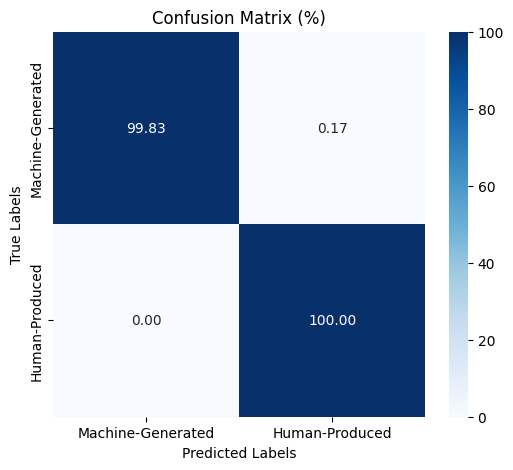

In [ ]:
predicted_labels = df_test_dataset.predicted_labels.to_list()
true_labels = df_test_dataset.target_labels.to_list()

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


Confusion Matrix:
[[599   1]
 [  0 600]]


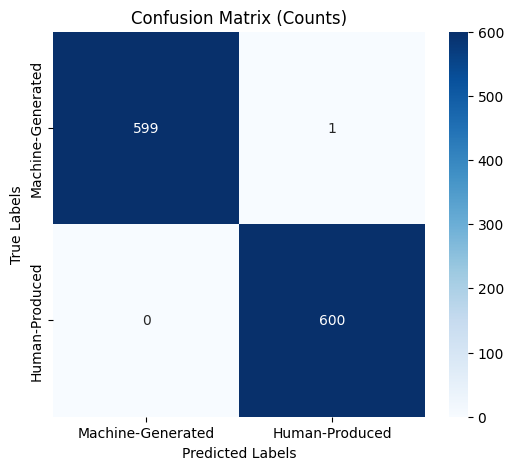

In [ ]:
predicted_labels = df_test_dataset.predicted_labels.to_list()
true_labels = df_test_dataset.target_labels.to_list()

# Calculate the confusion matrix without normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()

Accuracy: 0.9992
Precision: 1.0000
Recall: 0.9983


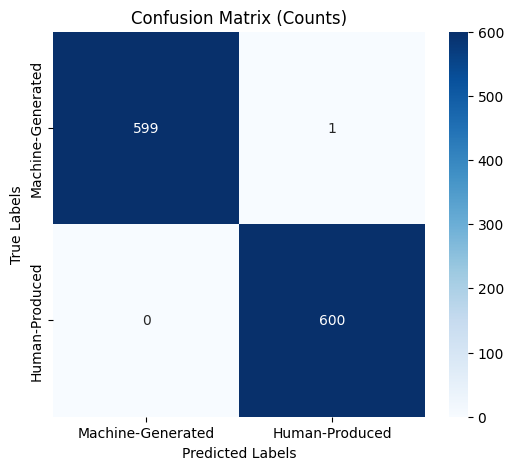

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming predicted_labels and true_labels are lists containing the labels from your dataset
predicted_labels = df_test_dataset.predicted_labels.to_list()
true_labels = df_test_dataset.target_labels.to_list()

# Calculate the confusion matrix without normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Extracting TP, TN, FP, FN
TP = cm[0, 0]  # True Positive: correct machine-generated predictions
FN = cm[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()


## Testing with merged dataset of human_generated and machine_generated paraphrased abstracts from held-out test_dataset

In [ ]:
# Paths to your JSONL files
old_test_path = "/content/drive/My Drive/dataset_with_n/arxiv_bloomz_test.jsonl"
new_test_path = "/content/drive/My Drive/dataset_with_n/arxiv_bloomz_paraphrased_full.jsonl"
filtered_new_test_path = "/content/drive/My Drive/dataset_with_n/arxiv_bloomz_paraphrased_filtered.jsonl"

# Function to read a JSONL file and return a list of entries
def read_jsonl_file(path):
    data = []
    with open(path, 'r') as file:
        for line in file:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                continue  # Skip lines that are not valid JSON
    return data

# Load the old and new test datasets
old_test_data = read_jsonl_file(old_test_path)
new_test_data = read_jsonl_file(new_test_path)

# Extract source_ids from the old test dataset
old_test_source_ids = {entry['source_id'] for entry in old_test_data}
print("old_test_source_ids:", old_test_source_ids)

# Filter new test data to only include entries whose source_id is in the old test data
filtered_new_test_data = [entry for entry in new_test_data if entry['source_id'] in old_test_source_ids]

filtered_new_test_source_ids = {entry['source_id'] for entry in filtered_new_test_data}
print("filtered_new_test_source_ids:", filtered_new_test_source_ids)

# Save the filtered new test data to a new JSONL file
with open(filtered_new_test_path, 'w') as outfile:
    for entry in filtered_new_test_data:
        json.dump(entry, outfile)
        outfile.write('\n')  # Write each JSON object on a new line

print(f"Filtered {len(filtered_new_test_data)} entries to {filtered_new_test_path}")


old_test_source_ids: {704.0841, 705.0404, 705.2279, 706.1505, 705.0273, 704.2454, 705.1837, 704.2529, 705.4543, 705.1418, 705.4412, 704.3236, 704.0758, 704.3829, 704.0106, 704.0556, 704.2494, 704.0259, 704.1761, 704.3177, 704.07, 705.165, 705.2368, 705.0538, 705.1145, 705.2993, 705.1365, 705.1788, 705.1918, 705.11, 705.3402, 705.0556, 705.0763, 704.3438, 704.2345, 706.132, 706.0619, 706.043, 706.0196, 706.0637, 706.1127, 706.1401, 706.0673, 706.052, 706.1977, 705.4146, 704.1615, 705.3966, 704.3408, 706.0404, 704.2184, 704.3097, 706.1392, 704.2704, 704.0492, 704.0361, 705.0706, 705.245, 704.2756, 705.1069, 705.2813, 704.0668, 705.2345, 705.1301, 705.4089, 704.336, 705.169, 705.1248, 704.1315, 705.0204, 705.4242, 704.0326, 704.0672, 704.3748, 704.1729, 704.0191, 704.0007, 704.2075, 704.0272, 704.3986, 704.0164, 705.2311, 705.218, 705.2592, 705.038, 705.3154, 705.4139, 705.4557, 705.4238, 705.4382, 705.3253, 705.2507, 705.069, 706.0107, 706.0732, 704.2067, 706.0515, 706.0798, 706.0614, 70

In [ ]:
print(old_test_source_ids == filtered_new_test_source_ids)

True


In [ ]:
paraphrased_test_data = load_jsonl_to_dataset(filtered_new_test_path)

In [ ]:
paraphrased_test_dataset = prepare_dataset(paraphrased_test_data)

In [ ]:
len(paraphrased_test_dataset)

1200

In [ ]:
# Define the directory where the model and tokenizer are located
model_directory = "/content/drive/My Drive/bloomz-560m-academic-detector-finetuned"

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
model = AutoModelForSequenceClassification.from_pretrained(model_directory)

# Create a classification pipeline
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)

def classify_text(example):
    # This function will be applied to each example
    predictions = classifier(example['text'])
    # Assuming the most likely label's id is returned directly
    return {'predicted_labels': predictions[0]['label']}

# Apply the classification to all texts in the dataset and add the predicted_labels column
paraphrased_test_dataset = paraphrased_test_dataset.map(classify_text, batched=False)

# Check the first few entries to verify
print(paraphrased_test_dataset[0])
print(paraphrased_test_dataset[1])

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': '  A rather non-standard quantum representation of the canonical commutation\nrelations of quantum mechanics systems, known as the polymer representation has\ngained some attention in recent years, due to its possible relation with Planck\nscale physics. In particular, this approach has been followed in a symmetric\nsector of loop quantum gravity known as loop quantum cosmology. Here we explore\ndifferent aspects of the relation between the ordinary Schroedinger theory and\nthe polymer description. The paper has two parts. In the first one, we derive\nthe polymer quantum mechanics starting from the ordinary Schroedinger theory\nand show that the polymer description arises as an appropriate limit. In the\nsecond part we consider the continuum limit of this theory, namely, the reverse\nprocess in which one starts from the discrete theory and tries to recover back\nthe ordinary Schroedinger quantum mechanics. We consider several examples of\ninterest, including the harmonic oscil

In [ ]:
print(paraphrased_test_dataset)

Dataset({
    features: ['text', 'labels', 'predicted_labels'],
    num_rows: 1200
})


In [ ]:
df_paraphrased_test_dataset = paraphrased_test_dataset.to_pandas()
df_paraphrased_test_dataset['target_labels'] = df_paraphrased_test_dataset['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')

In [ ]:
df_paraphrased_test_dataset.head(5)

,text,labels,predicted_labels,target_labels
0,A rather non-standard quantum representation...,0,human-produced,human-produced
1,The present work is devoted to the study of qu...,1,machine-generated,machine-generated
2,In this manuscript we investigate the capabi...,0,human-produced,human-produced
3,The Discrete Dipole Approximation (DDA) is use...,1,machine-generated,machine-generated
4,The aim of the present paper is to provide a...,0,human-produced,human-produced


Confusion Matrix in Percentage:
[[ 99.83333333   0.16666667]
 [  0.         100.        ]]


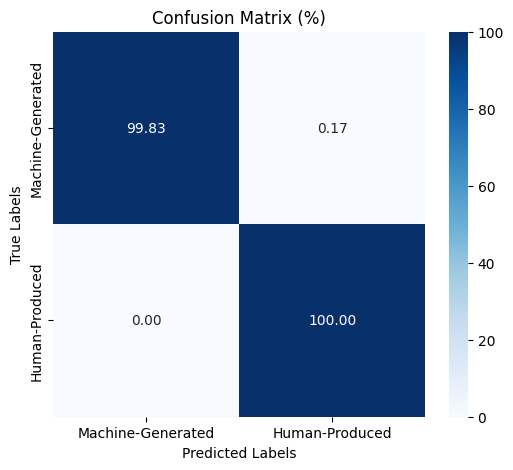

In [ ]:
predicted_labels = df_paraphrased_test_dataset.predicted_labels.to_list()
true_labels = df_paraphrased_test_dataset.target_labels.to_list()

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


Confusion Matrix:
[[599   1]
 [  0 600]]


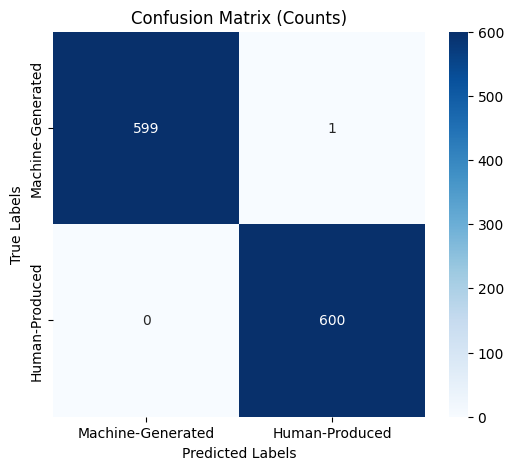

In [ ]:
predicted_labels = df_paraphrased_test_dataset.predicted_labels.to_list()
true_labels = df_paraphrased_test_dataset.target_labels.to_list()

# Calculate the confusion matrix without normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()

Accuracy: 0.9992
Precision: 1.0000
Recall: 0.9983


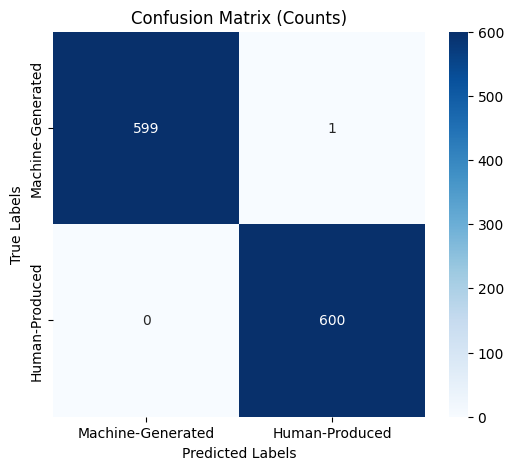

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming predicted_labels and true_labels are lists containing the labels from your dataset
predicted_labels = df_paraphrased_test_dataset.predicted_labels.to_list()
true_labels = df_paraphrased_test_dataset.target_labels.to_list()

# Calculate the confusion matrix without normalization
cm_p = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Extracting TP, TN, FP, FN
TP = cm_p[0, 0]  # True Positive: correct machine-generated predictions
FN = cm_p[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm_p[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm_p[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm_p)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_p, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()


# Testing with test_data from ChatGPT

In [ ]:
chatgpt_test_path = "/content/drive/My Drive/dataset_with_n/arxiv_chatGPT_test.jsonl"

In [ ]:
chatgpt_test_data = load_jsonl_to_dataset(chatgpt_test_path)

In [ ]:
def prepare_dataset_other_llm(data, abstract = 'abstract', machine_abstract = 'machine_abstract'):
    examples = []
    labels = []

    # Append text and labels for human and machine texts
    for example in data:
        examples.append(example[abstract])
        labels.append(0)  # Human text label
        examples.append(example[machine_abstract])
        labels.append(1)  # Machine text label

    # Creating a dataset
    dataset = Dataset.from_dict({"text": examples, "labels": labels})

    return dataset

In [ ]:
chatgpt_test_dataset = prepare_dataset_other_llm(chatgpt_test_data, 'human_text', 'machine_text')

In [ ]:
len(chatgpt_test_dataset)

1200

In [ ]:
print(chatgpt_test_dataset)

Dataset({
    features: ['text', 'labels'],
    num_rows: 1200
})


In [ ]:
# Define the directory where the model and tokenizer are located
model_directory = "/content/drive/My Drive/bloomz-560m-academic-detector-finetuned"

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
model = AutoModelForSequenceClassification.from_pretrained(model_directory)

# Create a classification pipeline
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)

def classify_text(example):
    # This function will be applied to each example
    predictions = classifier(example['text'])
    # Assuming the most likely label's id is returned directly
    return {'predicted_labels': predictions[0]['label']}

# Apply the classification to all texts in the dataset and add the predicted_labels column
chatgpt_test_dataset = chatgpt_test_dataset.map(classify_text, batched=False)

# Check the first few entries to verify
print(chatgpt_test_dataset[0])
print(chatgpt_test_dataset[1])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': "  We address the problem of constructing high-accuracy, faithful analytic\nwaveforms describing the gravitational wave signal emitted by inspiralling and\ncoalescing binary black holes. We work within the Effective-One-Body (EOB)\nframework and propose a methodology for improving the current\n(waveform)implementations of this framework based on understanding, element by\nelement, the physics behind each feature of the waveform, and on systematically\ncomparing various EOB-based waveforms with ``exact'' waveforms obtained by\nnumerical relativity approaches. The present paper focuses on small-mass-ratio\nnon-spinning binary systems, which can be conveniently studied by\nRegge-Wheeler-Zerilli-type methods. Our results include: (i) a resummed,\n3PN-accurate description of the inspiral waveform, (ii) a better description of\nradiation reaction during the plunge, (iii) a refined analytic expression for\nthe plunge waveform, (iv) an improved treatment of the matching between the\np

In [ ]:
print(chatgpt_test_dataset)

Dataset({
    features: ['text', 'labels', 'predicted_labels'],
    num_rows: 1200
})


In [ ]:
df_chatgpt_test_dataset = chatgpt_test_dataset.to_pandas()
df_chatgpt_test_dataset['target_labels'] = df_chatgpt_test_dataset['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')

In [ ]:
df_chatgpt_test_dataset.head(5)

,text,labels,predicted_labels,target_labels
0,We address the problem of constructing high-...,0,human-produced,human-produced
1,"In this work, we present a novel approach to t...",1,machine-generated,machine-generated
2,We propose a pairing-based method for coolin...,0,human-produced,human-produced
3,We present our work on pairing based cooling o...,1,machine-generated,machine-generated
4,Energetic feedback processes during the form...,0,human-produced,human-produced


Confusion Matrix in Percentage:
[[100.   0.]
 [  0. 100.]]


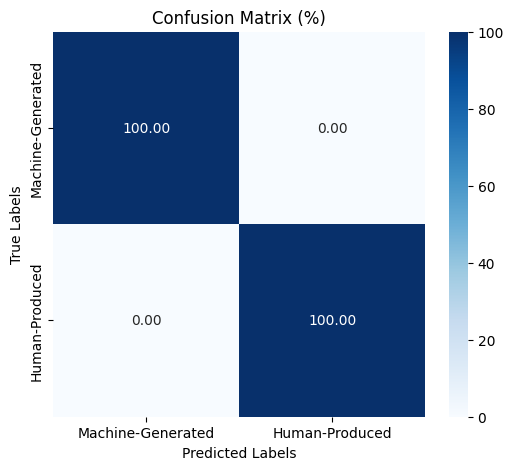

In [ ]:
predicted_labels = df_chatgpt_test_dataset.predicted_labels.to_list()
true_labels = df_chatgpt_test_dataset.target_labels.to_list()

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


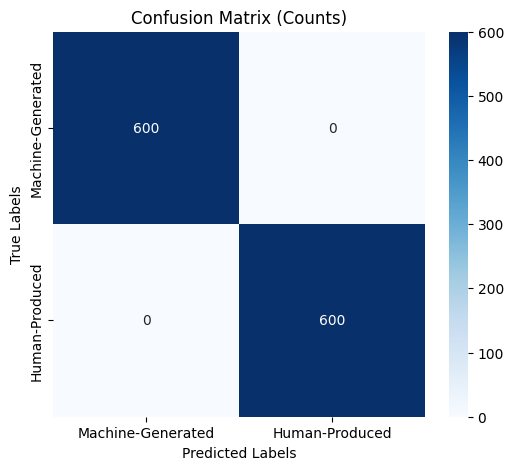

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming predicted_labels and true_labels are lists containing the labels from your dataset
predicted_labels = df_chatgpt_test_dataset.predicted_labels.to_list()
true_labels = df_chatgpt_test_dataset.target_labels.to_list()

# Calculate the confusion matrix without normalization
cm_c = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Extracting TP, TN, FP, FN
TP = cm_c[0, 0]  # True Positive: correct machine-generated predictions
FN = cm_c[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm_c[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm_c[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm_c)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_c, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()


# Testing with test_data from Cohere

In [ ]:
bloomz_test_path2 = "/content/drive/My Drive/dataset_with_n/arxiv_bloomz_test.jsonl"
new_test_path2 = "/content/drive/My Drive/dataset_with_n/arxiv_cohere_test.jsonl"

# Function to read a JSONL file and return a list of entries
def read_jsonl_file(path):
    data = []
    with open(path, 'r') as file:
        for line in file:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                continue  # Skip lines that are not valid JSON
    return data

bloomz_test_data2 = read_jsonl_file(bloomz_test_path2)
new_test_data2 = read_jsonl_file(new_test_path2)

# Extract source_ids from the old test dataset
bloomz_test_source_ids = {entry['source_id'] for entry in bloomz_test_data2}
print("bloomz_test_source_ids:", bloomz_test_source_ids)

new_test_source_ids = {entry['source_id'] for entry in new_test_data2}
print("new_test_source_ids:", new_test_source_ids)

print(bloomz_test_source_ids == new_test_source_ids)

bloomz_test_source_ids: {704.0841, 705.0404, 705.2279, 706.1505, 705.0273, 704.2454, 705.1837, 704.2529, 705.4543, 705.1418, 705.4412, 704.3236, 704.0758, 704.3829, 704.0106, 704.0556, 704.2494, 704.0259, 704.1761, 704.3177, 704.07, 705.165, 705.2368, 705.0538, 705.1145, 705.2993, 705.1365, 705.1788, 705.1918, 705.11, 705.3402, 705.0556, 705.0763, 704.3438, 704.2345, 706.132, 706.0619, 706.043, 706.0196, 706.0637, 706.1127, 706.1401, 706.0673, 706.052, 706.1977, 705.4146, 704.1615, 705.3966, 704.3408, 706.0404, 704.2184, 704.3097, 706.1392, 704.2704, 704.0492, 704.0361, 705.0706, 705.245, 704.2756, 705.1069, 705.2813, 704.0668, 705.2345, 705.1301, 705.4089, 704.336, 705.169, 705.1248, 704.1315, 705.0204, 705.4242, 704.0326, 704.0672, 704.3748, 704.1729, 704.0191, 704.0007, 704.2075, 704.0272, 704.3986, 704.0164, 705.2311, 705.218, 705.2592, 705.038, 705.3154, 705.4139, 705.4557, 705.4238, 705.4382, 705.3253, 705.2507, 705.069, 706.0107, 706.0732, 704.2067, 706.0515, 706.0798, 706.0614,

In [ ]:
cohere_test_path = "/content/drive/My Drive/dataset_with_n/arxiv_cohere_test.jsonl"

In [ ]:
cohere_test_data = load_jsonl_to_dataset(cohere_test_path)

In [ ]:
cohere_test_dataset = prepare_dataset_other_llm(cohere_test_data, 'human_text', 'machine_text')

In [ ]:
len(cohere_test_dataset)

1200

In [ ]:
print(cohere_test_dataset)

Dataset({
    features: ['text', 'labels'],
    num_rows: 1200
})


In [ ]:
# Define the directory where the model and tokenizer are located
model_directory = "/content/drive/My Drive/bloomz-560m-academic-detector-finetuned"

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
model = AutoModelForSequenceClassification.from_pretrained(model_directory)

# Create a classification pipeline
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)

def classify_text(example):
    # This function will be applied to each example
    predictions = classifier(example['text'])
    # Assuming the most likely label's id is returned directly
    return {'predicted_labels': predictions[0]['label']}

# Apply the classification to all texts in the dataset and add the predicted_labels column
cohere_test_dataset = cohere_test_dataset.map(classify_text, batched=False)

# Check the first few entries to verify
print(cohere_test_dataset[0])
print(cohere_test_dataset[1])

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': "  We address the problem of constructing high-accuracy, faithful analytic\nwaveforms describing the gravitational wave signal emitted by inspiralling and\ncoalescing binary black holes. We work within the Effective-One-Body (EOB)\nframework and propose a methodology for improving the current\n(waveform)implementations of this framework based on understanding, element by\nelement, the physics behind each feature of the waveform, and on systematically\ncomparing various EOB-based waveforms with ``exact'' waveforms obtained by\nnumerical relativity approaches. The present paper focuses on small-mass-ratio\nnon-spinning binary systems, which can be conveniently studied by\nRegge-Wheeler-Zerilli-type methods. Our results include: (i) a resummed,\n3PN-accurate description of the inspiral waveform, (ii) a better description of\nradiation reaction during the plunge, (iii) a refined analytic expression for\nthe plunge waveform, (iv) an improved treatment of the matching between the\np

In [ ]:
print(cohere_test_dataset)

Dataset({
    features: ['text', 'labels', 'predicted_labels'],
    num_rows: 1200
})


In [ ]:
df_cohere_test_dataset = cohere_test_dataset.to_pandas()
df_cohere_test_dataset['target_labels'] = df_cohere_test_dataset['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')

In [ ]:
df_cohere_test_dataset.head(5)

,text,labels,predicted_labels,target_labels
0,We address the problem of constructing high-...,0,human-produced,human-produced
1,\nWe study the effects of small-mass-ratio on ...,1,machine-generated,machine-generated
2,We propose a pairing-based method for coolin...,0,human-produced,human-produced
3,\n\nWe consider a recently proposed method to ...,1,machine-generated,machine-generated
4,Energetic feedback processes during the form...,0,human-produced,human-produced


Confusion Matrix in Percentage:
[[ 99.5   0.5]
 [  0.  100. ]]


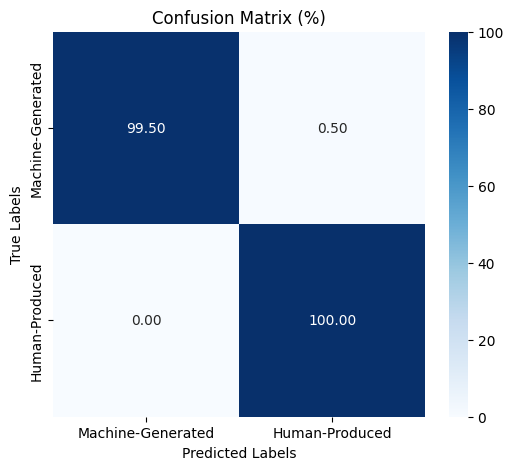

In [ ]:
predicted_labels = df_cohere_test_dataset.predicted_labels.to_list()
true_labels = df_cohere_test_dataset.target_labels.to_list()

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


Accuracy: 0.9975
Precision: 1.0000
Recall: 0.9950


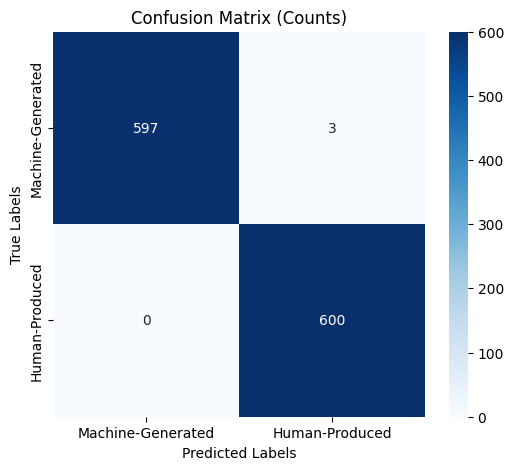

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming predicted_labels and true_labels are lists containing the labels from your dataset
predicted_labels = df_cohere_test_dataset.predicted_labels.to_list()
true_labels = df_cohere_test_dataset.target_labels.to_list()

# Calculate the confusion matrix without normalization
cm_cohere = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Extracting TP, TN, FP, FN
TP = cm_cohere[0, 0]  # True Positive: correct machine-generated predictions
FN = cm_cohere[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm_cohere[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm_cohere[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm_cohere)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_cohere, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()


# Testing with test_data from Flant5

In [ ]:
bloomz_test_path2 = "/content/drive/My Drive/dataset_with_n/arxiv_bloomz_test.jsonl"
new_test_path2 = "/content/drive/My Drive/dataset_with_n/arxiv_flant5_test.jsonl"

# Function to read a JSONL file and return a list of entries
def read_jsonl_file(path):
    data = []
    with open(path, 'r') as file:
        for line in file:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                continue  # Skip lines that are not valid JSON
    return data

bloomz_test_data2 = read_jsonl_file(bloomz_test_path2)
new_test_data2 = read_jsonl_file(new_test_path2)

# Extract source_ids from the old test dataset
bloomz_test_source_ids = {entry['source_id'] for entry in bloomz_test_data2}
print("bloomz_test_source_ids:", bloomz_test_source_ids)

new_test_source_ids = {entry['source_ID'] for entry in new_test_data2}
print("new_test_source_ids:", new_test_source_ids)

print(bloomz_test_source_ids == new_test_source_ids)

bloomz_test_source_ids: {704.0841, 705.0404, 705.2279, 706.1505, 705.0273, 704.2454, 705.1837, 704.2529, 705.4543, 705.1418, 705.4412, 704.3236, 704.0758, 704.3829, 704.0106, 704.0556, 704.2494, 704.0259, 704.1761, 704.3177, 704.07, 705.165, 705.2368, 705.0538, 705.1145, 705.2993, 705.1365, 705.1788, 705.1918, 705.11, 705.3402, 705.0556, 705.0763, 704.3438, 704.2345, 706.132, 706.0619, 706.043, 706.0196, 706.0637, 706.1127, 706.1401, 706.0673, 706.052, 706.1977, 705.4146, 704.1615, 705.3966, 704.3408, 706.0404, 704.2184, 704.3097, 706.1392, 704.2704, 704.0492, 704.0361, 705.0706, 705.245, 704.2756, 705.1069, 705.2813, 704.0668, 705.2345, 705.1301, 705.4089, 704.336, 705.169, 705.1248, 704.1315, 705.0204, 705.4242, 704.0326, 704.0672, 704.3748, 704.1729, 704.0191, 704.0007, 704.2075, 704.0272, 704.3986, 704.0164, 705.2311, 705.218, 705.2592, 705.038, 705.3154, 705.4139, 705.4557, 705.4238, 705.4382, 705.3253, 705.2507, 705.069, 706.0107, 706.0732, 704.2067, 706.0515, 706.0798, 706.0614,

In [ ]:
flant5_test_path = "/content/drive/My Drive/dataset_with_n/arxiv_flant5_test.jsonl"

In [ ]:
flant5_test_data = load_jsonl_to_dataset(flant5_test_path)

In [ ]:
flant5_test_dataset = prepare_dataset_other_llm(flant5_test_data, 'human_text', 'machine_text')

In [ ]:
len(flant5_test_dataset)

1200

In [ ]:
print(flant5_test_dataset)

Dataset({
    features: ['text', 'labels'],
    num_rows: 1200
})


In [ ]:
# Define the directory where the model and tokenizer are located
model_directory = "/content/drive/My Drive/bloomz-560m-academic-detector-finetuned"

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
model = AutoModelForSequenceClassification.from_pretrained(model_directory)

# Create a classification pipeline
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)

def classify_text(example):
    # This function will be applied to each example
    predictions = classifier(example['text'])
    # Assuming the most likely label's id is returned directly
    return {'predicted_labels': predictions[0]['label']}

# Apply the classification to all texts in the dataset and add the predicted_labels column
flant5_test_dataset = flant5_test_dataset.map(classify_text, batched=False)

# Check the first few entries to verify
print(flant5_test_dataset[0])
print(flant5_test_dataset[1])

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': "  We address the problem of constructing high-accuracy, faithful analytic\nwaveforms describing the gravitational wave signal emitted by inspiralling and\ncoalescing binary black holes. We work within the Effective-One-Body (EOB)\nframework and propose a methodology for improving the current\n(waveform)implementations of this framework based on understanding, element by\nelement, the physics behind each feature of the waveform, and on systematically\ncomparing various EOB-based waveforms with ``exact'' waveforms obtained by\nnumerical relativity approaches. The present paper focuses on small-mass-ratio\nnon-spinning binary systems, which can be conveniently studied by\nRegge-Wheeler-Zerilli-type methods. Our results include: (i) a resummed,\n3PN-accurate description of the inspiral waveform, (ii) a better description of\nradiation reaction during the plunge, (iii) a refined analytic expression for\nthe plunge waveform, (iv) an improved treatment of the matching between the\np

In [ ]:
print(flant5_test_dataset)

Dataset({
    features: ['text', 'labels', 'predicted_labels'],
    num_rows: 1200
})


In [ ]:
df_flant5_test_dataset = flant5_test_dataset.to_pandas()
df_flant5_test_dataset['target_labels'] = df_flant5_test_dataset['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')

In [ ]:
df_flant5_test_dataset.head(5)

,text,labels,predicted_labels,target_labels
0,We address the problem of constructing high-...,0,human-produced,human-produced
1,The paper presents the first faithful effectiv...,1,machine-generated,machine-generated
2,We propose a pairing-based method for coolin...,0,human-produced,human-produced
3,The cooling of Fermi gases is a challenging pr...,1,machine-generated,machine-generated
4,Energetic feedback processes during the form...,0,human-produced,human-produced


Confusion Matrix in Percentage:
[[100.   0.]
 [  0. 100.]]


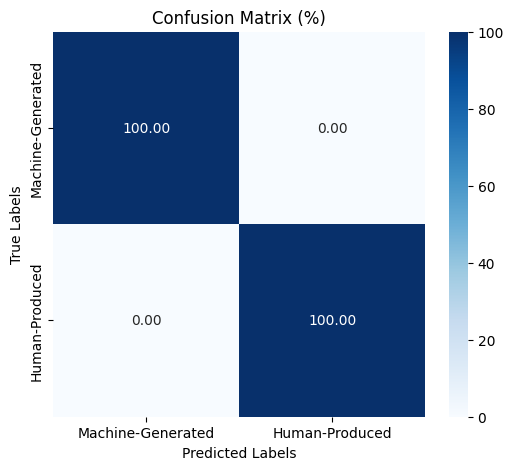

In [ ]:
predicted_labels = df_flant5_test_dataset.predicted_labels.to_list()
true_labels = df_flant5_test_dataset.target_labels.to_list()

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


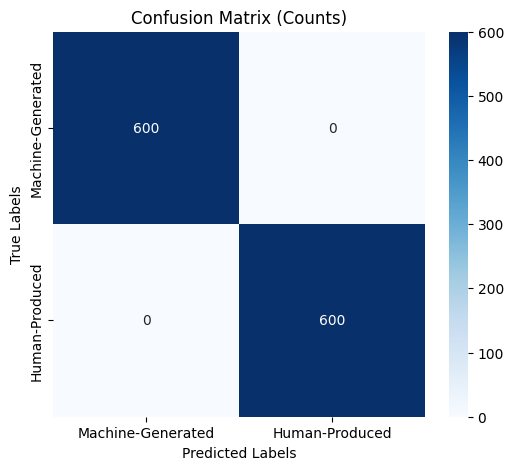

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming predicted_labels and true_labels are lists containing the labels from your dataset
predicted_labels = df_flant5_test_dataset.predicted_labels.to_list()
true_labels = df_flant5_test_dataset.target_labels.to_list()

# Calculate the confusion matrix without normalization
cm_f = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Extracting TP, TN, FP, FN
TP = cm_f[0, 0]  # True Positive: correct machine-generated predictions
FN = cm_f[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm_f[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm_f[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm_f)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_f, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()


# Testing with test_data from Davinci

In [ ]:
bloomz_test_path2 = "/content/drive/My Drive/dataset_with_n/arxiv_bloomz_test.jsonl"
new_test_path2 = "/content/drive/My Drive/dataset_with_n/arxiv_davinci_test.jsonl"

# Function to read a JSONL file and return a list of entries
def read_jsonl_file(path):
    data = []
    with open(path, 'r') as file:
        for line in file:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                continue  # Skip lines that are not valid JSON
    return data

bloomz_test_data2 = read_jsonl_file(bloomz_test_path2)
new_test_data2 = read_jsonl_file(new_test_path2)

# Extract source_ids from the old test dataset
bloomz_test_source_ids = {entry['source_id'] for entry in bloomz_test_data2}
print("bloomz_test_source_ids:", bloomz_test_source_ids)

new_test_source_ids = {entry['source_ID'] for entry in new_test_data2}
print("new_test_source_ids:", new_test_source_ids)

print(bloomz_test_source_ids == new_test_source_ids)

bloomz_test_source_ids: {704.0841, 705.0404, 705.2279, 706.1505, 705.0273, 704.2454, 705.1837, 704.2529, 705.4543, 705.1418, 705.4412, 704.3236, 704.0758, 704.3829, 704.0106, 704.0556, 704.2494, 704.0259, 704.1761, 704.3177, 704.07, 705.165, 705.2368, 705.0538, 705.1145, 705.2993, 705.1365, 705.1788, 705.1918, 705.11, 705.3402, 705.0556, 705.0763, 704.3438, 704.2345, 706.132, 706.0619, 706.043, 706.0196, 706.0637, 706.1127, 706.1401, 706.0673, 706.052, 706.1977, 705.4146, 704.1615, 705.3966, 704.3408, 706.0404, 704.2184, 704.3097, 706.1392, 704.2704, 704.0492, 704.0361, 705.0706, 705.245, 704.2756, 705.1069, 705.2813, 704.0668, 705.2345, 705.1301, 705.4089, 704.336, 705.169, 705.1248, 704.1315, 705.0204, 705.4242, 704.0326, 704.0672, 704.3748, 704.1729, 704.0191, 704.0007, 704.2075, 704.0272, 704.3986, 704.0164, 705.2311, 705.218, 705.2592, 705.038, 705.3154, 705.4139, 705.4557, 705.4238, 705.4382, 705.3253, 705.2507, 705.069, 706.0107, 706.0732, 704.2067, 706.0515, 706.0798, 706.0614,

In [ ]:
davinci_test_path = "/content/drive/My Drive/dataset_with_n/arxiv_davinci_test.jsonl"

In [ ]:
davinci_test_data = load_jsonl_to_dataset(davinci_test_path)

In [ ]:
davinci_test_dataset = prepare_dataset_other_llm(davinci_test_data, 'human_text', 'machine_text')

In [ ]:
len(davinci_test_dataset)

1200

In [ ]:
print(davinci_test_dataset)

Dataset({
    features: ['text', 'labels'],
    num_rows: 1200
})


In [ ]:
# Define the directory where the model and tokenizer are located
model_directory = "/content/drive/My Drive/bloomz-560m-academic-detector-finetuned"

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
model = AutoModelForSequenceClassification.from_pretrained(model_directory)

# Create a classification pipeline
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)

def classify_text(example):
    # This function will be applied to each example
    predictions = classifier(example['text'])
    # Assuming the most likely label's id is returned directly
    return {'predicted_labels': predictions[0]['label']}

# Apply the classification to all texts in the dataset and add the predicted_labels column
davinci_test_dataset = davinci_test_dataset.map(classify_text, batched=False)

# Check the first few entries to verify
print(davinci_test_dataset[0])
print(davinci_test_dataset[1])

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': '  We use new and published near-IR spectra, with synthetic spectra, to derive\nphysical properties of three of the latest-type T dwarfs. A new R~1700 spectrum\nof the T7.5 dwarf HD 3651B, with existing data, allows a detailed comparison to\nthe well-studied and very similar dwarf, Gl 570D. We find that HD 3651B has\nboth higher gravity and metallicity than Gl 570D, with Teff=820-830K, log g=\n5.4-5.5, [m/H]= +0.2 and Kzz=10^4cm^2/s. Its age is 8-12 Gyr and its implied\nmass is 60-70 M_Jup. We perform a similar analyis of the T8 and T7.5 dwarfs\n2MASS J09393548-2448279 and 2MASS J11145133-2618235 using published data,\ncomparing them to the well-studied T8, 2MASS J04151954-0935066. We find that\nthe two dwarfs have the same Teff as the reference dwarf, and similar\ngravities, but lower metallicities. The parameters are Teff=725-775K and [m/H]=\n-0.3; log g=5.3-5.45 for 2MASS J09393548-2448279 and log g=5.0-5.3 for 2MASS\nJ11145133- 261823. The age and mass are ~10Gyr and 60M_J

In [ ]:
print(davinci_test_dataset)

Dataset({
    features: ['text', 'labels', 'predicted_labels'],
    num_rows: 1200
})


In [ ]:
df_davinci_test_dataset = davinci_test_dataset.to_pandas()
df_davinci_test_dataset['target_labels'] = df_davinci_test_dataset['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')

In [ ]:
df_davinci_test_dataset.head(5)

,text,labels,predicted_labels,target_labels
0,"We use new and published near-IR spectra, wi...",0,human-produced,human-produced
1,We have studied the physical and spectral char...,1,machine-generated,machine-generated
2,Ongoing accretion onto galactic disks has be...,0,human-produced,human-produced
3,This article explores the concept of galactic ...,1,machine-generated,machine-generated
4,The spectrum of meson and diquark excitation...,0,human-produced,human-produced


Confusion Matrix in Percentage:
[[ 95.83333333   4.16666667]
 [  0.         100.        ]]


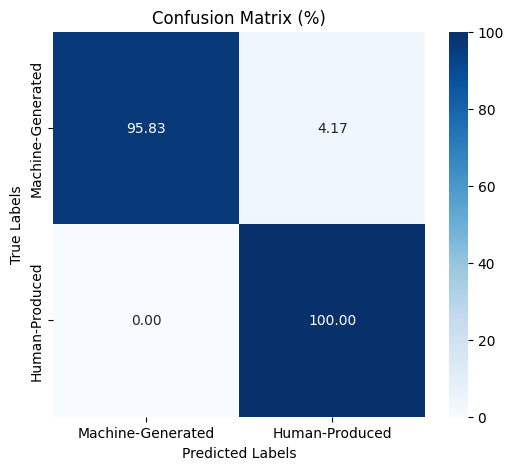

In [ ]:
predicted_labels = df_davinci_test_dataset.predicted_labels.to_list()
true_labels = df_davinci_test_dataset.target_labels.to_list()

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


Accuracy: 0.9792
Precision: 1.0000
Recall: 0.9583


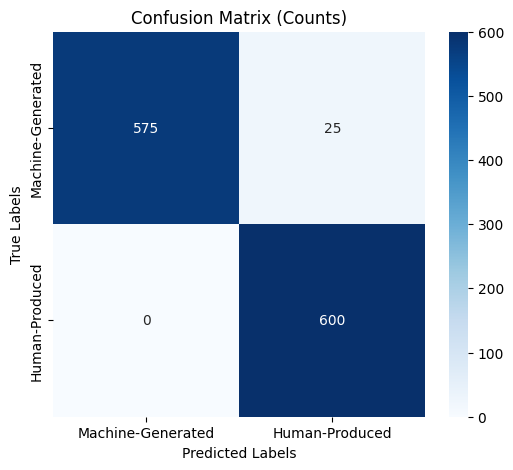

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming predicted_labels and true_labels are lists containing the labels from your dataset
predicted_labels = df_davinci_test_dataset.predicted_labels.to_list()
true_labels = df_davinci_test_dataset.target_labels.to_list()

# Calculate the confusion matrix without normalization
cm_dv = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Extracting TP, TN, FP, FN
TP = cm_dv[0, 0]  # True Positive: correct machine-generated predictions
FN = cm_dv[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm_dv[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm_dv[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm_dv)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dv, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()


# CROSS-DOMAIN TESTING - M4 WIKI DATA

# Testing with wikipedia_chatgpt_test

In [11]:
wikipedia_chatgpt_test_path = "/content/drive/My Drive/dataset_with_n/wiki/wikipedia_chatgpt_test.jsonl"

In [12]:
wikipedia_chatgpt_test_data = load_jsonl_to_dataset(wikipedia_chatgpt_test_path)

In [13]:
def prepare_dataset_other_llm(data, abstract = 'abstract', machine_abstract = 'machine_abstract'):
    examples = []
    labels = []

    # Append text and labels for human and machine texts
    for example in data:
        examples.append(example[abstract])
        labels.append(0)  # Human text label
        examples.append(example[machine_abstract])
        labels.append(1)  # Machine text label

    # Creating a dataset
    dataset = Dataset.from_dict({"text": examples, "labels": labels})

    return dataset

In [14]:
wikipedia_chatgpt_test_dataset = prepare_dataset_other_llm(wikipedia_chatgpt_test_data, 'human_text', 'machine_text')

In [15]:
len(wikipedia_chatgpt_test_dataset)

1198

In [16]:
print(wikipedia_chatgpt_test_dataset)

Dataset({
    features: ['text', 'labels'],
    num_rows: 1198
})


In [17]:
# Define the directory where the model and tokenizer are located
model_directory = "/content/drive/My Drive/bloomz-560m-academic-detector-finetuned"

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
model = AutoModelForSequenceClassification.from_pretrained(model_directory)

# Create a classification pipeline
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)

def classify_text(example):
    # This function will be applied to each example
    predictions = classifier(example['text'])
    # Assuming the most likely label's id is returned directly
    return {'predicted_labels': predictions[0]['label']}

# Apply the classification to all texts in the dataset and add the predicted_labels column
wikipedia_chatgpt_test_dataset = wikipedia_chatgpt_test_dataset.map(classify_text, batched=False)

# Check the first few entries to verify
print(wikipedia_chatgpt_test_dataset[0])
print(wikipedia_chatgpt_test_dataset[1])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Map:   0%|          | 0/1198 [00:00<?, ? examples/s]

{'text': 'The Dongas Tribe was a collection of road protesters and travellers in England, noted for their occupation of Twyford Down outside Winchester, Hampshire. The name Dongas comes from the Matabele word for "gully", given by Winchester locals to the deep drovers\' tracks on Twyford Down.\n\nJohn Vidal, writing in The Guardian in 2012, said of The Dongas that "the 15-20 urban youths who camped out to try to defend Twyford Down in 1992 are recognised to have fired up British environmental protest and kickstarted a major shift in green attitudes in both government and the public."\n\nHistory\n\nThe Twyford Down protest was a protest against the M3 motorway extension which destroyed some rich ecological sites, one of the very few habitats of the Chalkhill Blue butterfly and six species of rare orchid, and ancient monuments there (SSSI and Scheduled Ancient Monument). The Conservative government was planning to construct a new roadway through the area in order to save three minutes of

In [18]:
print(wikipedia_chatgpt_test_dataset)

Dataset({
    features: ['text', 'labels', 'predicted_labels'],
    num_rows: 1198
})


In [19]:
df_wikipedia_chatgpt_test_dataset = wikipedia_chatgpt_test_dataset.to_pandas()
df_wikipedia_chatgpt_test_dataset['target_labels'] = df_wikipedia_chatgpt_test_dataset['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')

In [20]:
df_wikipedia_chatgpt_test_dataset.head(5)

,text,labels,predicted_labels,target_labels
0,The Dongas Tribe was a collection of road prot...,0,machine-generated,human-produced
1,Dongas road protest group is an environmentali...,1,machine-generated,machine-generated
2,Sonakanda Fort is a river fort situated in Nar...,0,machine-generated,human-produced
3,Sonakanda Fort is an ancient fort located in t...,1,machine-generated,machine-generated
4,Persoonia stradbrokensis is a species of flowe...,0,machine-generated,human-produced


Confusion Matrix in Percentage:
[[100.           0.        ]
 [ 79.46577629  20.53422371]]


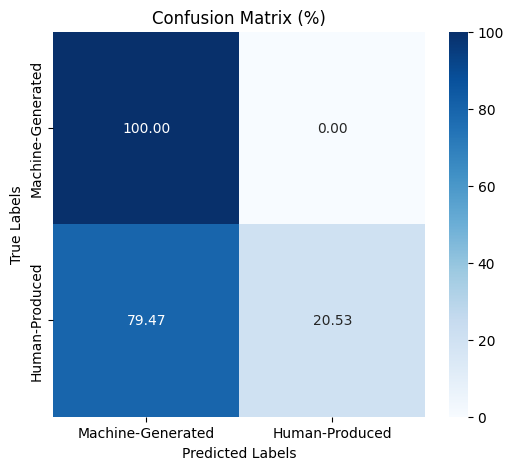

In [21]:
predicted_labels = df_wikipedia_chatgpt_test_dataset.predicted_labels.to_list()
true_labels = df_wikipedia_chatgpt_test_dataset.target_labels.to_list()

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


Accuracy: 0.6027
Precision: 0.5572
Recall: 1.0000


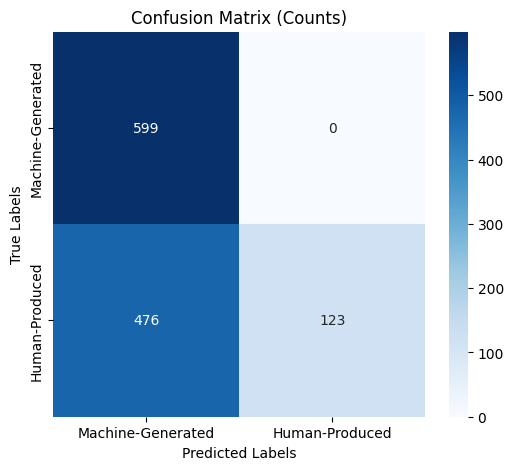

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming predicted_labels and true_labels are lists containing the labels from your dataset
predicted_labels = df_wikipedia_chatgpt_test_dataset.predicted_labels.to_list()
true_labels = df_wikipedia_chatgpt_test_dataset.target_labels.to_list()

# Calculate the confusion matrix without normalization
cm_dv = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Extracting TP, TN, FP, FN
TP = cm_dv[0, 0]  # True Positive: correct machine-generated predictions
FN = cm_dv[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm_dv[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm_dv[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm_dv)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dv, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()


# Testing with wikipedia_cohere_test

In [23]:
wikipedia_cohere_test_path = "/content/drive/My Drive/dataset_with_n/wiki/wikipedia_cohere_test.jsonl"

In [24]:
wikipedia_cohere_test_data = load_jsonl_to_dataset(wikipedia_cohere_test_path)

In [25]:
def prepare_dataset_other_llm(data, abstract = 'abstract', machine_abstract = 'machine_abstract'):
    examples = []
    labels = []

    # Append text and labels for human and machine texts
    for example in data:
        examples.append(example[abstract])
        labels.append(0)  # Human text label
        examples.append(example[machine_abstract])
        labels.append(1)  # Machine text label

    # Creating a dataset
    dataset = Dataset.from_dict({"text": examples, "labels": labels})

    return dataset

In [26]:
wikipedia_cohere_test_dataset = prepare_dataset_other_llm(wikipedia_cohere_test_data, 'human_text', 'machine_text')

In [27]:
len(wikipedia_cohere_test_dataset)

936

In [28]:
print(wikipedia_cohere_test_dataset)

Dataset({
    features: ['text', 'labels'],
    num_rows: 936
})


In [ ]:
# Define the directory where the model and tokenizer are located
model_directory = "/content/drive/My Drive/bloomz-560m-academic-detector-finetuned"

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
model = AutoModelForSequenceClassification.from_pretrained(model_directory)

# Create a classification pipeline
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)

def classify_text(example):
    # This function will be applied to each example
    predictions = classifier(example['text'])
    # Assuming the most likely label's id is returned directly
    return {'predicted_labels': predictions[0]['label']}

# Apply the classification to all texts in the dataset and add the predicted_labels column
wikipedia_cohere_test_dataset = wikipedia_cohere_test_dataset.map(classify_text, batched=False)

# Check the first few entries to verify
print(wikipedia_cohere_test_dataset[0])
print(wikipedia_cohere_test_dataset[1])

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Map:   0%|          | 0/936 [00:00<?, ? examples/s]

In [ ]:
print(wikipedia_cohere_test_dataset)

In [ ]:
df_wikipedia_cohere_test_dataset = wikipedia_cohere_test_dataset.to_pandas()
df_wikipedia_cohere_test_dataset['target_labels'] = df_wikipedia_cohere_test_dataset['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')

In [ ]:
df_wikipedia_cohere_test_dataset.head(5)

In [ ]:
predicted_labels = df_wikipedia_cohere_test_dataset.predicted_labels.to_list()
true_labels = df_wikipedia_cohere_test_dataset.target_labels.to_list()

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming predicted_labels and true_labels are lists containing the labels from your dataset
predicted_labels = df_wikipedia_cohere_test_dataset.predicted_labels.to_list()
true_labels = df_wikipedia_cohere_test_dataset.target_labels.to_list()

# Calculate the confusion matrix without normalization
cm_dv = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Extracting TP, TN, FP, FN
TP = cm_dv[0, 0]  # True Positive: correct machine-generated predictions
FN = cm_dv[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm_dv[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm_dv[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm_dv)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dv, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()


# TESTING WITH \\N REMOVED

## Testing with arxiv_bloomz_test

In [ ]:
arxiv_bloomz_test_path_n_removed = "/content/drive/My Drive/M4_without_n/arxiv_bloomz_test.jsonl"

In [ ]:
arxiv_bloomz_test_path_n_removed_data = load_jsonl_to_dataset(arxiv_bloomz_test_path_n_removed)

In [ ]:
def prepare_dataset_other_llm(data, abstract = 'abstract', machine_abstract = 'machine_abstract'):
    examples = []
    labels = []

    # Append text and labels for human and machine texts
    for example in data:
        examples.append(example[abstract])
        labels.append(0)  # Human text label
        examples.append(example[machine_abstract])
        labels.append(1)  # Machine text label

    # Creating a dataset
    dataset = Dataset.from_dict({"text": examples, "labels": labels})

    return dataset

In [ ]:
arxiv_bloomz_test_path_n_removed_dataset = prepare_dataset_other_llm(arxiv_bloomz_test_path_n_removed_data, 'abstract', 'machine_abstract')

In [ ]:
len(arxiv_bloomz_test_path_n_removed_dataset)

1200

In [ ]:
print(arxiv_bloomz_test_path_n_removed_dataset)

Dataset({
    features: ['text', 'labels'],
    num_rows: 1200
})


In [ ]:
# Define the directory where the model and tokenizer are located
model_directory = "/content/drive/My Drive/bloomz-560m-academic-detector-finetuned"

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
model = AutoModelForSequenceClassification.from_pretrained(model_directory)

# Create a classification pipeline
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)

def classify_text(example):
    # This function will be applied to each example
    predictions = classifier(example['text'])
    # Assuming the most likely label's id is returned directly
    return {'predicted_labels': predictions[0]['label']}

# Apply the classification to all texts in the dataset and add the predicted_labels column
arxiv_bloomz_test_path_n_removed_dataset = arxiv_bloomz_test_path_n_removed_dataset.map(classify_text, batched=False)

# Check the first few entries to verify
print(arxiv_bloomz_test_path_n_removed_dataset[0])
print(arxiv_bloomz_test_path_n_removed_dataset[1])

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': "  We address the problem of constructing high-accuracy, faithful analytic waveforms describing the gravitational wave signal emitted by inspiralling and coalescing binary black holes. We work within the Effective-One-Body (EOB) framework and propose a methodology for improving the current (waveform)implementations of this framework based on understanding, element by element, the physics behind each feature of the waveform, and on systematically comparing various EOB-based waveforms with ``exact'' waveforms obtained by numerical relativity approaches. The present paper focuses on small-mass-ratio non-spinning binary systems, which can be conveniently studied by Regge-Wheeler-Zerilli-type methods. Our results include: (i) a resummed, 3PN-accurate description of the inspiral waveform, (ii) a better description of radiation reaction during the plunge, (iii) a refined analytic expression for the plunge waveform, (iv) an improved treatment of the matching between the plunge and rin

In [ ]:
print(arxiv_bloomz_test_path_n_removed_dataset)

Dataset({
    features: ['text', 'labels', 'predicted_labels'],
    num_rows: 1200
})


In [ ]:
df_arxiv_bloomz_test_path_n_removed_dataset = arxiv_bloomz_test_path_n_removed_dataset.to_pandas()
df_arxiv_bloomz_test_path_n_removed_dataset['target_labels'] = df_arxiv_bloomz_test_path_n_removed_dataset['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')

In [ ]:
df_arxiv_bloomz_test_path_n_removed_dataset.head(5)

,text,labels,predicted_labels,target_labels
0,We address the problem of constructing high-...,0,machine-generated,human-produced
1,We present the first results for effective-one...,1,machine-generated,machine-generated
2,We propose a pairing-based method for coolin...,0,machine-generated,human-produced
3,We propose to cool fermionic atoms in optical ...,1,machine-generated,machine-generated
4,Energetic feedback processes during the form...,0,machine-generated,human-produced


Confusion Matrix in Percentage:
[[100.   0.]
 [100.   0.]]


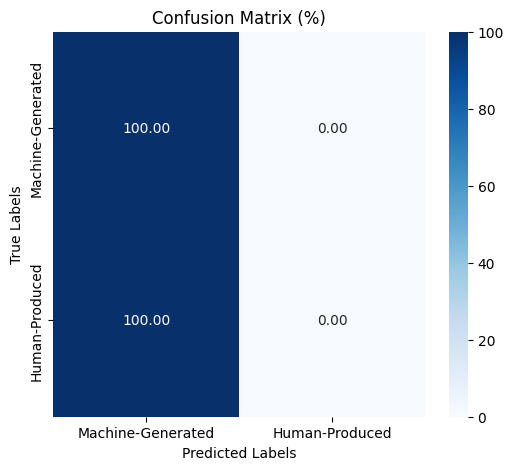

In [ ]:
predicted_labels = df_arxiv_bloomz_test_path_n_removed_dataset.predicted_labels.to_list()
true_labels = df_arxiv_bloomz_test_path_n_removed_dataset.target_labels.to_list()

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


Accuracy: 0.5000
Precision: 0.5000
Recall: 1.0000


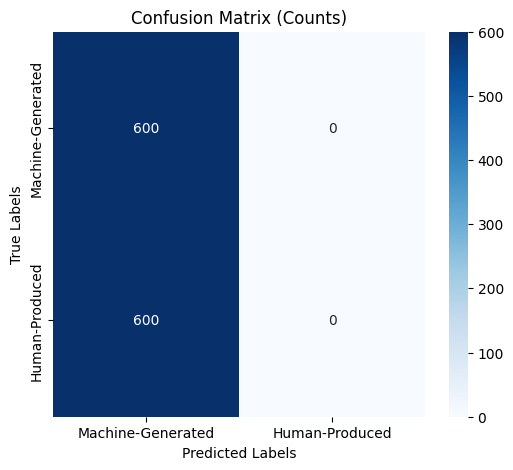

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming predicted_labels and true_labels are lists containing the labels from your dataset
predicted_labels = df_arxiv_bloomz_test_path_n_removed_dataset.predicted_labels.to_list()
true_labels = df_arxiv_bloomz_test_path_n_removed_dataset.target_labels.to_list()

# Calculate the confusion matrix without normalization
cm_dv = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Extracting TP, TN, FP, FN
TP = cm_dv[0, 0]  # True Positive: correct machine-generated predictions
FN = cm_dv[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm_dv[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm_dv[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm_dv)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dv, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()


## Testing with arxiv_chatGPT_test

In [ ]:
arxiv_chatGPT_test_path_n_removed = "/content/drive/My Drive/M4_without_n/arxiv_chatGPT_test.jsonl"

In [ ]:
arxiv_chatGPT_test_data_n_removed = load_jsonl_to_dataset(arxiv_chatGPT_test_path_n_removed)

In [ ]:
arxiv_chatGPT_test_n_removed_dataset = prepare_dataset_other_llm(arxiv_chatGPT_test_data_n_removed, 'human_text', 'machine_text')

In [ ]:
len(arxiv_chatGPT_test_n_removed_dataset)

1200

In [ ]:
print(arxiv_chatGPT_test_n_removed_dataset)

Dataset({
    features: ['text', 'labels'],
    num_rows: 1200
})


In [ ]:
# Define the directory where the model and tokenizer are located
model_directory = "/content/drive/My Drive/bloomz-560m-academic-detector-finetuned"

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
model = AutoModelForSequenceClassification.from_pretrained(model_directory)

# Create a classification pipeline
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)

def classify_text(example):
    # This function will be applied to each example
    predictions = classifier(example['text'])
    # Assuming the most likely label's id is returned directly
    return {'predicted_labels': predictions[0]['label']}

# Apply the classification to all texts in the dataset and add the predicted_labels column
arxiv_chatGPT_test_n_removed_dataset = arxiv_chatGPT_test_n_removed_dataset.map(classify_text, batched=False)

# Check the first few entries to verify
print(arxiv_chatGPT_test_n_removed_dataset[0])
print(arxiv_chatGPT_test_n_removed_dataset[1])

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': "  We address the problem of constructing high-accuracy, faithful analytic waveforms describing the gravitational wave signal emitted by inspiralling and coalescing binary black holes. We work within the Effective-One-Body (EOB) framework and propose a methodology for improving the current (waveform)implementations of this framework based on understanding, element by element, the physics behind each feature of the waveform, and on systematically comparing various EOB-based waveforms with ``exact'' waveforms obtained by numerical relativity approaches. The present paper focuses on small-mass-ratio non-spinning binary systems, which can be conveniently studied by Regge-Wheeler-Zerilli-type methods. Our results include: (i) a resummed, 3PN-accurate description of the inspiral waveform, (ii) a better description of radiation reaction during the plunge, (iii) a refined analytic expression for the plunge waveform, (iv) an improved treatment of the matching between the plunge and rin

In [ ]:
print(arxiv_chatGPT_test_n_removed_dataset)

Dataset({
    features: ['text', 'labels', 'predicted_labels'],
    num_rows: 1200
})


In [ ]:
df_arxiv_chatGPT_test_n_removed_dataset = arxiv_chatGPT_test_n_removed_dataset.to_pandas()
df_arxiv_chatGPT_test_n_removed_dataset['target_labels'] = df_arxiv_chatGPT_test_n_removed_dataset['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')

In [ ]:
df_arxiv_chatGPT_test_n_removed_dataset.head(5)

,text,labels,predicted_labels,target_labels
0,We address the problem of constructing high-...,0,machine-generated,human-produced
1,"In this work, we present a novel approach to t...",1,machine-generated,machine-generated
2,We propose a pairing-based method for coolin...,0,machine-generated,human-produced
3,We present our work on pairing based cooling o...,1,machine-generated,machine-generated
4,Energetic feedback processes during the form...,0,machine-generated,human-produced


Confusion Matrix in Percentage:
[[100.   0.]
 [100.   0.]]


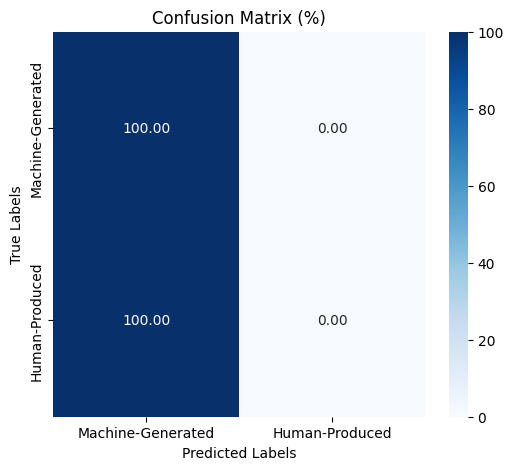

In [ ]:
predicted_labels = df_arxiv_chatGPT_test_n_removed_dataset.predicted_labels.to_list()
true_labels = df_arxiv_chatGPT_test_n_removed_dataset.target_labels.to_list()

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


Accuracy: 0.5000
Precision: 0.5000
Recall: 1.0000


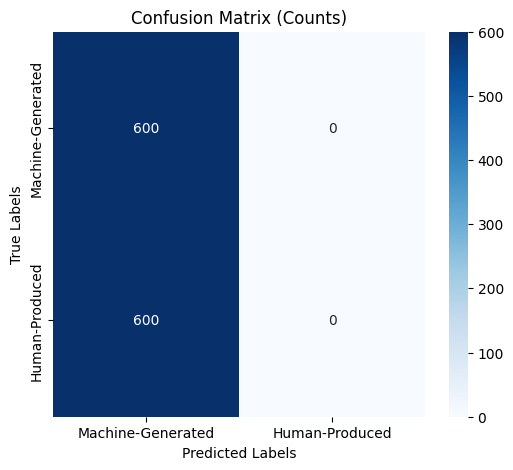

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming predicted_labels and true_labels are lists containing the labels from your dataset
predicted_labels = df_arxiv_chatGPT_test_n_removed_dataset.predicted_labels.to_list()
true_labels = df_arxiv_chatGPT_test_n_removed_dataset.target_labels.to_list()

# Calculate the confusion matrix without normalization
cm_dv = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Extracting TP, TN, FP, FN
TP = cm_dv[0, 0]  # True Positive: correct machine-generated predictions
FN = cm_dv[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm_dv[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm_dv[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm_dv)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dv, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()


## Testing with arxiv_cohere_test

In [ ]:
arxiv_cohere_test_path_n_removed = "/content/drive/My Drive/M4_without_n/arxiv_cohere_test.jsonl"

In [ ]:
arxiv_cohere_test_data_n_removed = load_jsonl_to_dataset(arxiv_cohere_test_path_n_removed)

In [ ]:
arxiv_cohere_test_n_removed_dataset = prepare_dataset_other_llm(arxiv_cohere_test_data_n_removed, 'human_text', 'machine_text')

In [ ]:
len(arxiv_cohere_test_n_removed_dataset)

1200

In [ ]:
print(arxiv_cohere_test_n_removed_dataset)

Dataset({
    features: ['text', 'labels'],
    num_rows: 1200
})


In [ ]:
# Define the directory where the model and tokenizer are located
model_directory = "/content/drive/My Drive/bloomz-560m-academic-detector-finetuned"

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
model = AutoModelForSequenceClassification.from_pretrained(model_directory)

# Create a classification pipeline
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)

def classify_text(example):
    # This function will be applied to each example
    predictions = classifier(example['text'])
    # Assuming the most likely label's id is returned directly
    return {'predicted_labels': predictions[0]['label']}

# Apply the classification to all texts in the dataset and add the predicted_labels column
arxiv_cohere_test_n_removed_dataset = arxiv_cohere_test_n_removed_dataset.map(classify_text, batched=False)

# Check the first few entries to verify
print(arxiv_cohere_test_n_removed_dataset[0])
print(arxiv_cohere_test_n_removed_dataset[1])

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': "  We address the problem of constructing high-accuracy, faithful analytic waveforms describing the gravitational wave signal emitted by inspiralling and coalescing binary black holes. We work within the Effective-One-Body (EOB) framework and propose a methodology for improving the current (waveform)implementations of this framework based on understanding, element by element, the physics behind each feature of the waveform, and on systematically comparing various EOB-based waveforms with ``exact'' waveforms obtained by numerical relativity approaches. The present paper focuses on small-mass-ratio non-spinning binary systems, which can be conveniently studied by Regge-Wheeler-Zerilli-type methods. Our results include: (i) a resummed, 3PN-accurate description of the inspiral waveform, (ii) a better description of radiation reaction during the plunge, (iii) a refined analytic expression for the plunge waveform, (iv) an improved treatment of the matching between the plunge and rin

In [ ]:
print(arxiv_cohere_test_n_removed_dataset)

Dataset({
    features: ['text', 'labels', 'predicted_labels'],
    num_rows: 1200
})


In [ ]:
df_arxiv_cohere_test_n_removed_dataset = arxiv_cohere_test_n_removed_dataset.to_pandas()
df_arxiv_cohere_test_n_removed_dataset['target_labels'] = df_arxiv_cohere_test_n_removed_dataset['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')

In [ ]:
df_arxiv_cohere_test_n_removed_dataset.head(5)

,text,labels,predicted_labels,target_labels
0,We address the problem of constructing high-...,0,machine-generated,human-produced
1,We study the effects of small-mass-ratio on t...,1,machine-generated,machine-generated
2,We propose a pairing-based method for coolin...,0,machine-generated,human-produced
3,We consider a recently proposed method to co...,1,machine-generated,machine-generated
4,Energetic feedback processes during the form...,0,machine-generated,human-produced


Confusion Matrix in Percentage:
[[100.   0.]
 [100.   0.]]


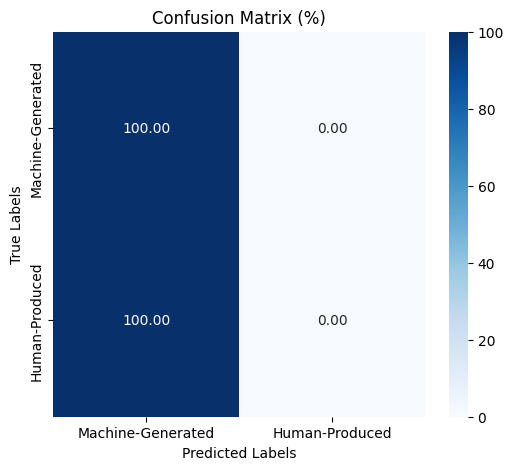

In [ ]:
predicted_labels = df_arxiv_cohere_test_n_removed_dataset.predicted_labels.to_list()
true_labels = df_arxiv_cohere_test_n_removed_dataset.target_labels.to_list()

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


Accuracy: 0.5000
Precision: 0.5000
Recall: 1.0000


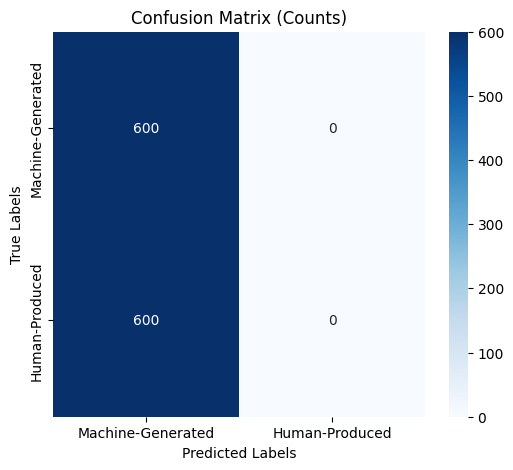

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming predicted_labels and true_labels are lists containing the labels from your dataset
predicted_labels = df_arxiv_cohere_test_n_removed_dataset.predicted_labels.to_list()
true_labels = df_arxiv_cohere_test_n_removed_dataset.target_labels.to_list()

# Calculate the confusion matrix without normalization
cm_dv = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Extracting TP, TN, FP, FN
TP = cm_dv[0, 0]  # True Positive: correct machine-generated predictions
FN = cm_dv[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm_dv[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm_dv[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm_dv)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dv, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()


## Testing with arxiv_davinci_test

In [ ]:
arxiv_davinci_test_path_n_removed = "/content/drive/My Drive/M4_without_n/arxiv_davinci_test.jsonl"

In [ ]:
arxiv_davinci_test_data_n_removed = load_jsonl_to_dataset(arxiv_davinci_test_path_n_removed)

In [ ]:
arxiv_davinci_test_n_removed_dataset = prepare_dataset_other_llm(arxiv_davinci_test_data_n_removed, 'human_text', 'machine_text')

In [ ]:
len(arxiv_davinci_test_n_removed_dataset)

1200

In [ ]:
print(arxiv_davinci_test_n_removed_dataset)

Dataset({
    features: ['text', 'labels'],
    num_rows: 1200
})


In [ ]:
# Define the directory where the model and tokenizer are located
model_directory = "/content/drive/My Drive/bloomz-560m-academic-detector-finetuned"

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
model = AutoModelForSequenceClassification.from_pretrained(model_directory)

# Create a classification pipeline
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)

def classify_text(example):
    # This function will be applied to each example
    predictions = classifier(example['text'])
    # Assuming the most likely label's id is returned directly
    return {'predicted_labels': predictions[0]['label']}

# Apply the classification to all texts in the dataset and add the predicted_labels column
arxiv_davinci_test_n_removed_dataset = arxiv_davinci_test_n_removed_dataset.map(classify_text, batched=False)

# Check the first few entries to verify
print(arxiv_davinci_test_n_removed_dataset[0])
print(arxiv_davinci_test_n_removed_dataset[1])

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': '  We use new and published near-IR spectra, with synthetic spectra, to derive physical properties of three of the latest-type T dwarfs. A new R~1700 spectrum of the T7.5 dwarf HD 3651B, with existing data, allows a detailed comparison to the well-studied and very similar dwarf, Gl 570D. We find that HD 3651B has both higher gravity and metallicity than Gl 570D, with Teff=820-830K, log g= 5.4-5.5, [m/H]= +0.2 and Kzz=10^4cm^2/s. Its age is 8-12 Gyr and its implied mass is 60-70 M_Jup. We perform a similar analyis of the T8 and T7.5 dwarfs 2MASS J09393548-2448279 and 2MASS J11145133-2618235 using published data, comparing them to the well-studied T8, 2MASS J04151954-0935066. We find that the two dwarfs have the same Teff as the reference dwarf, and similar gravities, but lower metallicities. The parameters are Teff=725-775K and [m/H]= -0.3; log g=5.3-5.45 for 2MASS J09393548-2448279 and log g=5.0-5.3 for 2MASS J11145133- 261823. The age and mass are ~10Gyr and 60M_Jup for 2MASS

In [ ]:
print(arxiv_davinci_test_n_removed_dataset)

Dataset({
    features: ['text', 'labels', 'predicted_labels'],
    num_rows: 1200
})


In [ ]:
df_arxiv_davinci_test_n_removed_dataset = arxiv_davinci_test_n_removed_dataset.to_pandas()
df_arxiv_davinci_test_n_removed_dataset['target_labels'] = df_arxiv_davinci_test_n_removed_dataset['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')

In [ ]:
df_arxiv_davinci_test_n_removed_dataset.head(5)

,text,labels,predicted_labels,target_labels
0,"We use new and published near-IR spectra, wi...",0,machine-generated,human-produced
1,We have studied the physical and spectral char...,1,machine-generated,machine-generated
2,Ongoing accretion onto galactic disks has be...,0,machine-generated,human-produced
3,This article explores the concept of galactic ...,1,machine-generated,machine-generated
4,The spectrum of meson and diquark excitation...,0,machine-generated,human-produced


Confusion Matrix in Percentage:
[[100.   0.]
 [100.   0.]]


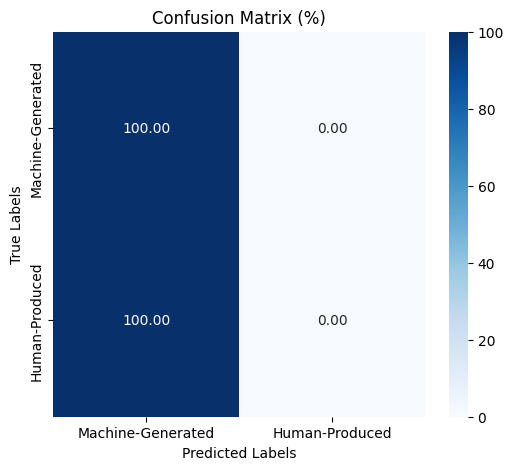

In [ ]:
predicted_labels = df_arxiv_davinci_test_n_removed_dataset.predicted_labels.to_list()
true_labels = df_arxiv_davinci_test_n_removed_dataset.target_labels.to_list()

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


Accuracy: 0.5000
Precision: 0.5000
Recall: 1.0000


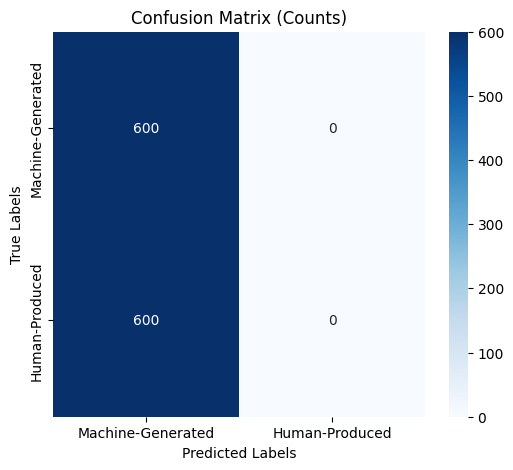

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming predicted_labels and true_labels are lists containing the labels from your dataset
predicted_labels = df_arxiv_davinci_test_n_removed_dataset.predicted_labels.to_list()
true_labels = df_arxiv_davinci_test_n_removed_dataset.target_labels.to_list()

# Calculate the confusion matrix without normalization
cm_dv = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Extracting TP, TN, FP, FN
TP = cm_dv[0, 0]  # True Positive: correct machine-generated predictions
FN = cm_dv[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm_dv[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm_dv[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm_dv)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dv, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()


## Testing with arxiv_flant5_test

In [ ]:
arxiv_flant5_test_path_n_removed = "/content/drive/My Drive/M4_without_n/arxiv_flant5_test.jsonl"

In [ ]:
arxiv_flant5_test_data_n_removed = load_jsonl_to_dataset(arxiv_flant5_test_path_n_removed)

In [ ]:
arxiv_flant5_test_n_removed_dataset = prepare_dataset_other_llm(arxiv_flant5_test_data_n_removed, 'human_text', 'machine_text')

In [ ]:
len(arxiv_flant5_test_n_removed_dataset)

1200

In [ ]:
print(arxiv_flant5_test_n_removed_dataset)

Dataset({
    features: ['text', 'labels'],
    num_rows: 1200
})


In [ ]:
# Define the directory where the model and tokenizer are located
model_directory = "/content/drive/My Drive/bloomz-560m-academic-detector-finetuned"

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
model = AutoModelForSequenceClassification.from_pretrained(model_directory)

# Create a classification pipeline
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)

def classify_text(example):
    # This function will be applied to each example
    predictions = classifier(example['text'])
    # Assuming the most likely label's id is returned directly
    return {'predicted_labels': predictions[0]['label']}

# Apply the classification to all texts in the dataset and add the predicted_labels column
arxiv_flant5_test_n_removed_dataset = arxiv_flant5_test_n_removed_dataset.map(classify_text, batched=False)

# Check the first few entries to verify
print(arxiv_flant5_test_n_removed_dataset[0])
print(arxiv_flant5_test_n_removed_dataset[1])

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': "  We address the problem of constructing high-accuracy, faithful analytic waveforms describing the gravitational wave signal emitted by inspiralling and coalescing binary black holes. We work within the Effective-One-Body (EOB) framework and propose a methodology for improving the current (waveform)implementations of this framework based on understanding, element by element, the physics behind each feature of the waveform, and on systematically comparing various EOB-based waveforms with ``exact'' waveforms obtained by numerical relativity approaches. The present paper focuses on small-mass-ratio non-spinning binary systems, which can be conveniently studied by Regge-Wheeler-Zerilli-type methods. Our results include: (i) a resummed, 3PN-accurate description of the inspiral waveform, (ii) a better description of radiation reaction during the plunge, (iii) a refined analytic expression for the plunge waveform, (iv) an improved treatment of the matching between the plunge and rin

In [ ]:
print(arxiv_flant5_test_n_removed_dataset)

Dataset({
    features: ['text', 'labels', 'predicted_labels'],
    num_rows: 1200
})


In [ ]:
df_arxiv_flant5_test_n_removed_dataset = arxiv_flant5_test_n_removed_dataset.to_pandas()
df_arxiv_flant5_test_n_removed_dataset['target_labels'] = df_arxiv_flant5_test_n_removed_dataset['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')

In [ ]:
df_arxiv_flant5_test_n_removed_dataset.head(5)

,text,labels,predicted_labels,target_labels
0,We address the problem of constructing high-...,0,machine-generated,human-produced
1,The paper presents the first faithful effectiv...,1,machine-generated,machine-generated
2,We propose a pairing-based method for coolin...,0,machine-generated,human-produced
3,The cooling of Fermi gases is a challenging pr...,1,machine-generated,machine-generated
4,Energetic feedback processes during the form...,0,machine-generated,human-produced


Confusion Matrix in Percentage:
[[100.   0.]
 [100.   0.]]


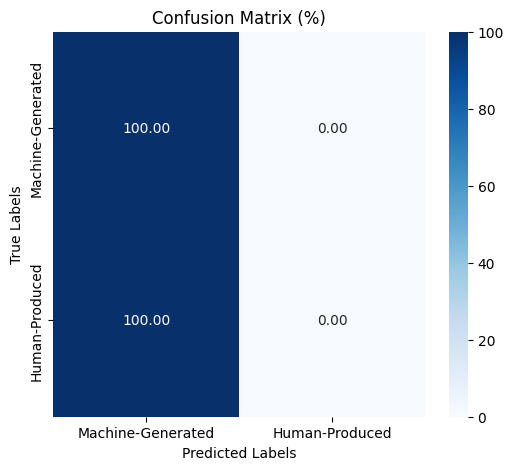

In [ ]:
predicted_labels = df_arxiv_flant5_test_n_removed_dataset.predicted_labels.to_list()
true_labels = df_arxiv_flant5_test_n_removed_dataset.target_labels.to_list()

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


Accuracy: 0.5000
Precision: 0.5000
Recall: 1.0000


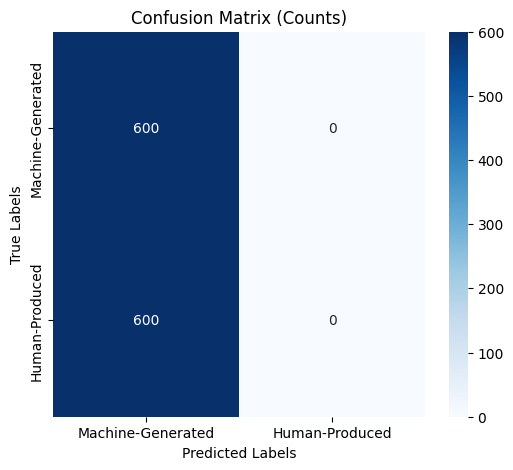

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming predicted_labels and true_labels are lists containing the labels from your dataset
predicted_labels = df_arxiv_flant5_test_n_removed_dataset.predicted_labels.to_list()
true_labels = df_arxiv_flant5_test_n_removed_dataset.target_labels.to_list()

# Calculate the confusion matrix without normalization
cm_dv = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Extracting TP, TN, FP, FN
TP = cm_dv[0, 0]  # True Positive: correct machine-generated predictions
FN = cm_dv[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm_dv[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm_dv[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm_dv)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dv, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()
